<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/HW5/Prac/3D_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Image Segmentation

In this notebook, our focus is on employing both 2D-UNet and 3D-UNet models to perform segmentation on a set of 30 volumetric medical images.

# Imports

In [ ]:
import cv2
import torch
import numpy as np
# from blocks import *
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import random
from matplotlib import pyplot as plt
import sklearn

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE" -O dataset.npy && rm -rf /tmp/cookies.txt

--2024-01-07 09:10:17--  https://docs.google.com/uc?export=download&confirm=t&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE
Resolving docs.google.com (docs.google.com)... 142.251.12.113, 142.251.12.139, 142.251.12.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o8b8qfmgpqvtac1a6cmaulmi3hleiad0/1704618600000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=225134c1-b882-414e-9e26-eb5b6efb9854 [following]
--2024-01-07 09:10:18--  https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o8b8qfmgpqvtac1a6cmaulmi3hleiad0/1704618600000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=225134c1-b882-414e-9e26-eb5b6efb9854
Resolving doc-0k-60-docs.googleusercontent.com (doc-0k-60-docs.googleusercontent.com)... 74.125.24.132, 2

In [ ]:
dataset_path = 'dataset.npy'
labeled_images = np.load(dataset_path, allow_pickle=True)
ORGAN_idx = 6
ORGAN = 'liver'
image_shape = (128, 128)
image_slices = 208

In [ ]:
data_X = []
data_Y = []

for idx in range(len(labeled_images)):
    xx = labeled_images[idx].get("image")
    yy = labeled_images[idx].get("label")

    yy[np.where(yy != ORGAN_idx)] = 0
    yy[np.where(yy == ORGAN_idx)] = 1

    x = []
    y = []
    for i in range(len(xx)):
        x.append(cv2.resize(xx[i,:,:], image_shape))
        y.append(cv2.resize(yy[i,:,:], image_shape))

    x = np.asarray(x)
    y = np.asarray(y)

    npad = [(0, 0)] * 3
    slices = image_slices - x.shape[0]
    npad[0] = (0, slices)
    x_pad = np.pad(x, npad)
    y_pad = np.pad(y, npad)
    data_X.append([x_pad])
    data_Y.append([y_pad])
s
data_X = np.asarray(data_X)
data_Y = np.asarray(data_Y)
print(data_X.shape)
print(data_Y.shape)

(30, 1, 208, 128, 128)
(30, 1, 208, 128, 128)


In [ ]:
n_train, n_valid, n_test = 20, 5, 5

train_X = data_X[:n_train]
train_Y = data_Y[:n_train]

valid_X = data_X[n_train:n_train+n_valid]
valid_Y = data_Y[n_train:n_train+n_valid]

test_X = data_X[n_train+n_valid:]
test_Y = data_Y[n_train+n_valid:]

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)
print(test_X.shape, test_Y.shape)

(20, 1, 208, 128, 128) (20, 1, 208, 128, 128)
(5, 1, 208, 128, 128) (5, 1, 208, 128, 128)
(5, 1, 208, 128, 128) (5, 1, 208, 128, 128)


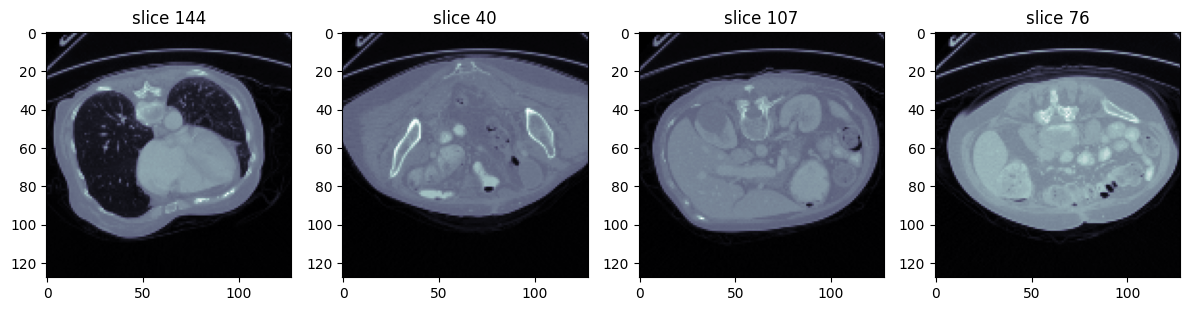

In [ ]:

def visualize_random_slice(img, k):
  i=0
  fig, axs = plt.subplots(1,k, figsize=(3*k,3))
  slices = img.shape[1]

  while i< k:

    idx = random.randint(0, slices)
    rnd_slice = img[:, idx]

    if not np.all(rnd_slice == 0):
      axs[i].title.set_text("slice "+str(idx))
      axs[i].imshow(rnd_slice[0], cmap='bone')
      i+= 1

  fig.tight_layout()


index = random.randint(0, train_X.shape[0]-1)

visualize_random_slice(train_X[index], 4)

# Utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

In [ ]:
def calculate_dice_score(pred_mask, gt_mask):
    intersection = torch.sum(pred_mask * gt_mask)
    total_pixels = torch.sum(pred_mask) + torch.sum(gt_mask)
    dice = (2.0 * intersection) / (total_pixels + 1e-8)  # Adding a small epsilon to avoid division by zero
    return dice

In [ ]:
def dice_score(y_pred_bin, y_true):
    """
    Args:
        y_pred_bin: shape => (batch_size, 1, h, w)
        y_true: shape => (batch_size, 1, h, w)

    Returns:
        : shape => (batch_size, dice_score)
    """

    dice_scores = []
    for pred_mask, gt_mask in zip(y_pred_bin, y_true):
        dice = calculate_dice_score(pred_mask, gt_mask)
        dice_scores.append(dice)
    return dice_scores

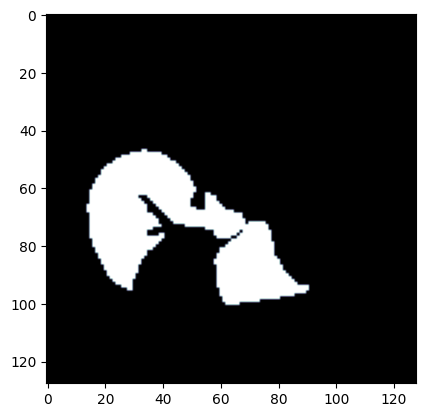

In [ ]:
plt.imshow(train_Y[15, :,70][0], cmap='bone')

In [ ]:
def one_epoch(model, loader, criterion, optimizer, scheduler, device, samples_count, phase):
  if phase == 'train':
    model.train()  # Set model to training mode
  else:
     model.eval()

  running_loss = 0.0
  running_dice = 0.0

  # Iterate over data.
  for inputs, labels, idicies in loader:
    inputs = inputs.type(torch.FloatTensor).to(device)
    labels = labels.type(torch.LongTensor).to(device)


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1, keepdim=True)
      loss = criterion(outputs, labels[:,0])

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()
    running_dice += torch.sum(torch.stack(dice_score(preds, labels)))

    # if phase == 'train' and not scheduler:
    #     scheduler.step()

  loss = running_loss / len(loader)
  dice = running_dice / samples_count[phase]

  return loss, dice.cpu()

In [ ]:
def train(model, loaders, criterion, optimizer, num_epochs, device, model_path, samples_count,scheduler=None):

  best_valid_loss = float('inf')
  best_valid_dice = 0

  dice_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['valid'] = [], []
  dice_dic['train'], dice_dic['valid'] = [], []

  for epoch in range(num_epochs):
      train_loss, train_dice = one_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, samples_count, phase='train')
      val_loss, val_dice = one_epoch(model, loaders['valid'], criterion, optimizer, scheduler, device, samples_count, phase='valid')

      loss_dic['train'].append(train_loss)
      loss_dic['valid'].append(val_loss)
      dice_dic['train'].append(train_dice)
      dice_dic['valid'].append(val_dice)

      if val_dice > best_valid_dice:
        best_valid_dice = val_dice
        best_valid_loss = val_loss
        torch.save(model.state_dict(), model_path)

      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Dice: {train_dice:.4f} - '
            f'Valid Loss: {val_loss:.4f} - '
            f'Valid Dice {val_dice:.4f}')

  return loss_dic, dice_dic

In [ ]:
def evaluate(model, loaders, criterion, optimizer, device, samples_count, phase, scheduler=None):
  test_loss, test_dice = one_epoch(model, loaders[phase], criterion, optimizer, scheduler, device, samples_count, phase)
  print(f'Test Loss: {test_loss:.4f} - '
            f'Test Dice {test_dice:.4f}')

In [ ]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  plt.plot(e, data['valid'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

# Part 1: 2D UNet

In this section we are going to use a 2D UNet to train a segmentation model.

## Part 1.1: Model Definition

In [ ]:
class First2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout=False):
        super(First2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)


class Encoder2D(nn.Module):
    def __init__(
            self, in_channels, middle_channels, out_channels,
            dropout=False, downsample_kernel=2
    ):
        super(Encoder2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=downsample_kernel),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class Center2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Center2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.center = nn.Sequential(*layers)

    def forward(self, x):
        return self.center(x)


class Decoder2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Decoder2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class Last2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, softmax=False):
        super(Last2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=1),
            # nn.Softmax(dim=1)
        ]

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)

In [ ]:
class UNet2D(nn.Module):

    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'
        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # Encode
        encode_block1 = self.encoder_layers[0](x)
        encode_block2 = self.encoder_layers[1](encode_block1)
        encode_block3 = self.encoder_layers[2](encode_block2)
        encode_block4 = self.encoder_layers[3](encode_block3)

        # Bottleneck
        bottleneck1 = self.center(encode_block4)


        # Decode
        cat_layer4 = torch.cat((bottleneck1, encode_block4), dim=1)
        decode_block4 = self.decoder_layers[0](cat_layer4)

        cat_layer3 = torch.cat((decode_block4, encode_block3), dim=1)
        decode_block3 = self.decoder_layers[1](cat_layer3)

        cat_layer2 = torch.cat((decode_block3, encode_block2), dim=1)
        decode_block2 = self.decoder_layers[2](cat_layer2)

        cat_layer1 = torch.cat((decode_block2, encode_block1), dim=1)
        decode_block1 = self.decoder_layers[3](cat_layer1)

        return decode_block1

## Part 1.2: Dataset Definition

In [ ]:
class Dataset2D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.slices_x = []
        self.slices_y = []
        for i in range(x.shape[0]): # each image
            for j in range(x.shape[2]): # each slice
                sx = x[i, :, j, :, :]
                sy = y[i, :, j, :, :]
                if sy.sum() > 0:
                    self.slices_x.append(sx)
                    self.slices_y.append(sy)
    def __len__(self):
        return len(self.slices_x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.slices_x[index]
        y = self.slices_y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 1.3: Train

In [ ]:
model2d = UNet2D(in_channels=1, out_channels=2)
model2d.to(device).float()
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()
epochs = 50

In [ ]:
train_loader2d = DataLoader(
    Dataset2D(train_X, train_Y, Normalization=True),
    batch_size=32,
    shuffle=True,
    num_workers=2
)

print('Train Loader Done')

valid_loader2d = DataLoader(
    Dataset2D(valid_X, valid_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print('Validation Loader Done')

test_loader2d = DataLoader(
    Dataset2D(test_X, test_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print('Test Loader Done')

train_samples_count2d = len(train_loader2d.dataset)
val_samples_count2d = len(valid_loader2d.dataset)
test_samples_count2d = len(test_loader2d.dataset)

samples_count2d = {
    'train': train_samples_count2d,
    'valid':val_samples_count2d,
    'test': test_samples_count2d
}

Train Loader Done
Validation Loader Done
Test Loader Done


In [ ]:
dataloaders2d = {
    'train': train_loader2d,
    'valid': valid_loader2d,
    'test': test_loader2d
}

In [ ]:
# model2d_path = '/content/model2d.pt'
model2d_path = '/content/drive/MyDrive/AI/Deep Learning/SPB/HW5/model2d.pt'

In [ ]:
loss_dic, dice_dic = train(model2d, dataloaders2d, criterion, optimizer, epochs, device, model2d_path, samples_count2d)

Epoch [1/50] - Train Loss: 0.2058 - Train Dice: 0.0005 - Valid Loss: 1.9311 - Valid Dice 0.0000
Epoch [2/50] - Train Loss: 0.1495 - Train Dice: 0.0000 - Valid Loss: 0.1247 - Valid Dice 0.0000
Epoch [3/50] - Train Loss: 0.1160 - Train Dice: 0.1086 - Valid Loss: 0.1101 - Valid Dice 0.2455
Epoch [4/50] - Train Loss: 0.1008 - Train Dice: 0.5040 - Valid Loss: 0.0923 - Valid Dice 0.2769
Epoch [5/50] - Train Loss: 0.0929 - Train Dice: 0.5330 - Valid Loss: 0.1559 - Valid Dice 0.0322
Epoch [6/50] - Train Loss: 0.0892 - Train Dice: 0.5337 - Valid Loss: 0.1447 - Valid Dice 0.4802
Epoch [7/50] - Train Loss: 0.0829 - Train Dice: 0.5714 - Valid Loss: 0.1896 - Valid Dice 0.1774
Epoch [8/50] - Train Loss: 0.0818 - Train Dice: 0.5650 - Valid Loss: 0.0773 - Valid Dice 0.4504
Epoch [9/50] - Train Loss: 0.0767 - Train Dice: 0.5914 - Valid Loss: 0.0696 - Valid Dice 0.5827
Epoch [10/50] - Train Loss: 0.0711 - Train Dice: 0.6006 - Valid Loss: 0.0707 - Valid Dice 0.4377
Epoch [11/50] - Train Loss: 0.0696 - Tr

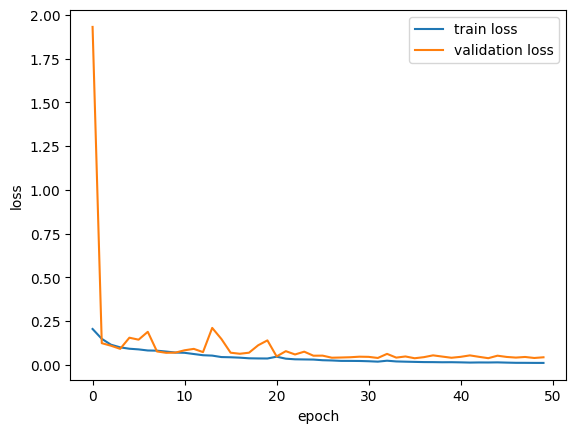

In [ ]:
show_plots(epochs, loss_dic, 'loss')

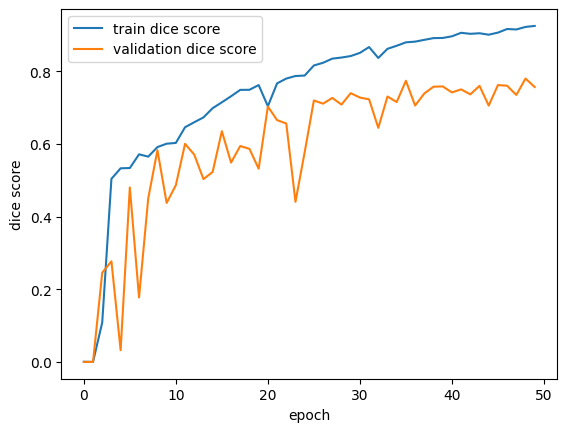

In [ ]:
show_plots(epochs, dice_dic, 'dice score')

In [ ]:
model2d.load_state_dict(torch.load(model2d_path))

<All keys matched successfully>

In [ ]:
evaluate(model2d, dataloaders2d, criterion, optimizer, device, samples_count2d, 'test')

Test Loss: 0.0621 - Test Dice 0.7935


# Part 2: 3D UNet

Now we want to use a 3D model and see if we can get better results

## Part 2.1: Model Definition

In [ ]:
class First3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout=False):
        super(First3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)


class Encoder3D(nn.Module):
    def __init__(
            self, in_channels, middle_channels, out_channels,
            dropout=False, downsample_kernel=2
    ):
        super(Encoder3D, self).__init__()

        layers = [
            nn.MaxPool3d(kernel_size=downsample_kernel),
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class Center3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Center3D, self).__init__()

        layers = [
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.center = nn.Sequential(*layers)

    def forward(self, x):
        return self.center(x)


class Decoder3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Decoder3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class Last3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, softmax=False):
        super(Last3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=1),
            # nn.Softmax(dim=1)
        ]

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet3D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First3D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder3D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder3D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last3D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center3D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # Encode
        encode_block1 = self.encoder_layers[0](x)
        encode_block2 = self.encoder_layers[1](encode_block1)
        encode_block3 = self.encoder_layers[2](encode_block2)
        encode_block4 = self.encoder_layers[3](encode_block3)

        # Bottleneck
        bottleneck1 = self.center(encode_block4)


        # Decode
        cat_layer4 = torch.cat((bottleneck1, encode_block4), dim=1)
        decode_block4 = self.decoder_layers[0](cat_layer4)

        cat_layer3 = torch.cat((decode_block4, encode_block3), dim=1)
        decode_block3 = self.decoder_layers[1](cat_layer3)

        cat_layer2 = torch.cat((decode_block3, encode_block2), dim=1)
        decode_block2 = self.decoder_layers[2](cat_layer2)

        cat_layer1 = torch.cat((decode_block2, encode_block1), dim=1)
        decode_block1 = self.decoder_layers[3](cat_layer1)

        return decode_block1

## Part 2.2: Dataset Definition

In [ ]:
class Dataset3D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.x[index]
        y = self.y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 2.3: Train

In [ ]:
model3d = UNet3D(in_channels=1, out_channels=2)
model3d = model3d.to(device).float()
optimizer = torch.optim.Adam(model3d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 50

In [ ]:
train_loader3d = DataLoader(
    Dataset3D(train_X, train_Y, Normalization=True),
    batch_size=1,
    shuffle=True,
    num_workers=2
)

print('Train Loader Done')

valid_loader3d = DataLoader(
    Dataset3D(valid_X, valid_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=2
)

print('Validation Loader Done')

test_loader3d = DataLoader(
    Dataset3D(test_X, test_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=2
)

print('Test Loader Done')

train_samples_count3d = len(train_loader3d.dataset)
val_samples_count3d = len(valid_loader3d.dataset)
test_samples_count3d = len(test_loader3d.dataset)

samples_count3d = {
    'train': train_samples_count3d,
    'valid':val_samples_count3d,
    'test': test_samples_count3d
}

Train Loader Done
Validation Loader Done
Test Loader Done


In [ ]:
dataloaders3d = {
    'train': train_loader3d,
    'valid': valid_loader3d,
    'test': test_loader3d
}

In [ ]:
# model3d_path = '/content/model3d.pt'
model3d_path = '/content/drive/MyDrive/AI/Deep Learning/SPB/HW5/model3d.pt'

In [ ]:
loss_dic, dice_dic = train(model3d, dataloaders3d, criterion, optimizer, epochs, device, model3d_path, samples_count3d)

Epoch [1/50] - Train Loss: 0.4241 - Train Dice: 0.0269 - Valid Loss: 0.3306 - Valid Dice 0.2280
Epoch [2/50] - Train Loss: 0.2828 - Train Dice: 0.1483 - Valid Loss: 0.2476 - Valid Dice 0.3505
Epoch [3/50] - Train Loss: 0.2174 - Train Dice: 0.2918 - Valid Loss: 0.1974 - Valid Dice 0.3346
Epoch [4/50] - Train Loss: 0.1705 - Train Dice: 0.5750 - Valid Loss: 0.1508 - Valid Dice 0.7052
Epoch [5/50] - Train Loss: 0.1344 - Train Dice: 0.6912 - Valid Loss: 0.1211 - Valid Dice 0.7521
Epoch [6/50] - Train Loss: 0.1074 - Train Dice: 0.7158 - Valid Loss: 0.0985 - Valid Dice 0.7717
Epoch [7/50] - Train Loss: 0.0875 - Train Dice: 0.7748 - Valid Loss: 0.0803 - Valid Dice 0.7979
Epoch [8/50] - Train Loss: 0.0722 - Train Dice: 0.7979 - Valid Loss: 0.0745 - Valid Dice 0.4651
Epoch [9/50] - Train Loss: 0.0637 - Train Dice: 0.7737 - Valid Loss: 0.0578 - Valid Dice 0.7933
Epoch [10/50] - Train Loss: 0.0543 - Train Dice: 0.8079 - Valid Loss: 0.0515 - Valid Dice 0.8225
Epoch [11/50] - Train Loss: 0.0475 - Tr

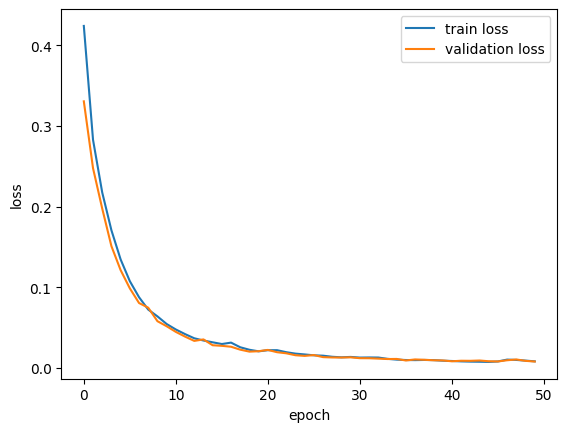

In [ ]:
show_plots(epochs, loss_dic, 'loss')

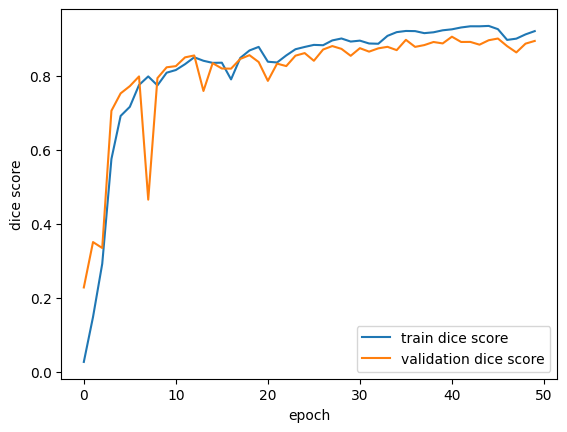

In [ ]:
show_plots(epochs, dice_dic, 'dice score')

In [ ]:
model3d.load_state_dict(torch.load(model3d_path))

<All keys matched successfully>

In [ ]:
evaluate(model3d, dataloaders3d, criterion, optimizer, device, samples_count3d, 'test')

Test Loss: 0.0114 - Test Dice 0.8904


# Visualization

In the final section we visualize segmentation masks for a few random slices for both 2D and 3D model

In [ ]:
# model2d = UNet2D(in_channels=1, out_channels=2)
# model3d = UNet3D(in_channels=1, out_channels=2)
# model2d_path = '/content/drive/MyDrive/AI/Deep Learning/SPB/HW5/model2d.pt'
# model3d_path = '/content/drive/MyDrive/AI/Deep Learning/SPB/HW5/model3d.pt'

In [ ]:
model2d.load_state_dict(torch.load(model2d_path))
model3d.load_state_dict(torch.load(model3d_path))

<All keys matched successfully>

In [ ]:
def predict(model, image):
  input = torch.from_numpy(np.array([image])).type(torch.float)
  model.cpu()
  model.eval()
  outputs = model(input)
  _, preds = torch.max(outputs, 1, keepdim=True)
  return preds[0]


In [ ]:
def get_slice_indicies(img, k):
  indicies = []
  i=0
  while i < k:

    idx = random.randint(0, slices-1)
    rnd_slice = img[:, idx]

    if not np.all(rnd_slice == 0):
      indicies.append(idx)
      i+= 1
  return indicies


In [ ]:
index = random.randint(0, test_X.shape[0]-1)
img, mask = dataloaders3d['test'].dataset[index][0], dataloaders3d['test'].dataset[index][1]
slices = img.shape[1]

In [ ]:
pred3d =  predict(model3d ,img)

In [ ]:
k = 4
slice_indicies = get_slice_indicies(mask, k)
slice_indicies

[118, 83, 113, 91]

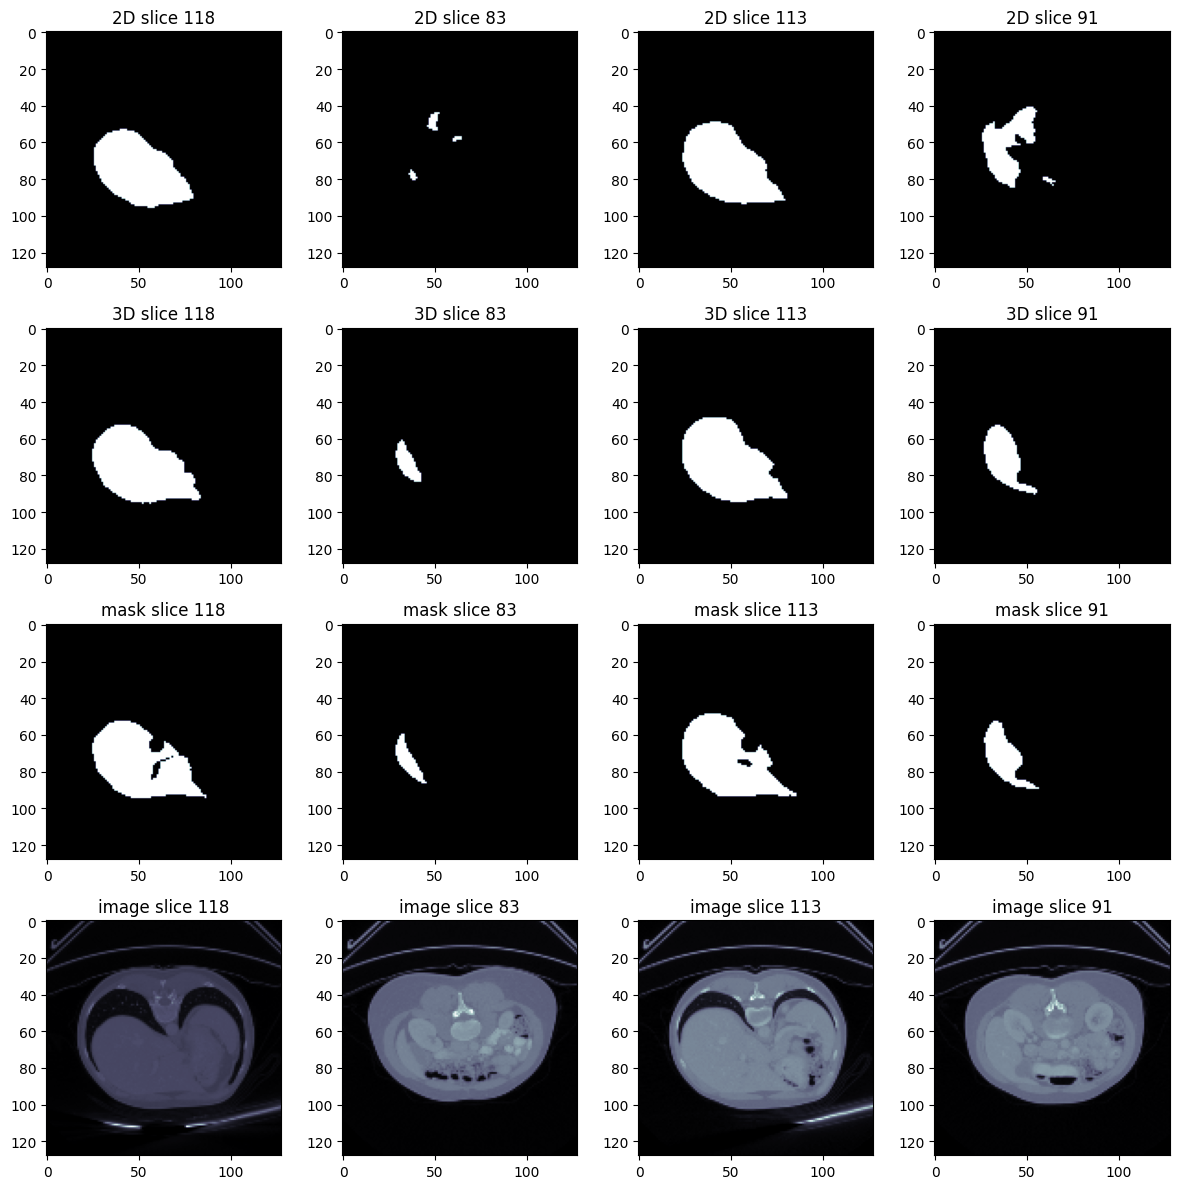

In [ ]:
fig, axs = plt.subplots(4, k, figsize=(3*k,12))
for i, s in enumerate(slice_indicies):

  pred2d = predict(model2d, img[:, s])

  axs[0][i].title.set_text("2D slice "+str(s))
  axs[0][i].imshow(pred2d[0], cmap='bone')

  axs[1][i].title.set_text("3D slice "+str(s))
  axs[1][i].imshow(pred3d[:, s][0], cmap='bone')

  axs[2][i].title.set_text("mask slice "+str(s))
  axs[2][i].imshow(mask[:, s][0], cmap='bone')

  axs[3][i].title.set_text("image slice "+str(s))
  axs[3][i].imshow(img[:, s][0], cmap='bone')

fig.tight_layout()